In [2]:
# Modified by Nipun from:

# https://github.com/google-research/bert/blob/master/predicting_movie_reviews_with_bert_on_tf_hub.ipynb

# Copyright 2019 Google Inc.

# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at

#     http://www.apache.org/licenses/LICENSE-2.0

# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [1]:
# install tf version 1 
!pip install "tensorflow>=1.15,<2.0"
# ! sign: It means run it as a shell command rather than a notebook command. It's the same as if you opened up a terminal and typed it without the !
# install BERT python package
!pip install bert-tensorflow==1.0.1
!pip install --upgrade tensorflow-hub

You should consider upgrading via the 'c:\users\t1nipun\appdata\local\continuum\anaconda3\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\t1nipun\appdata\local\continuum\anaconda3\python.exe -m pip install --upgrade pip' command.
You should consider upgrading via the 'c:\users\t1nipun\appdata\local\continuum\anaconda3\python.exe -m pip install --upgrade pip' command.


In [33]:
#from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime

In [34]:
import numpy as np

In [36]:
import bert
from bert import run_classifier
from bert import optimization
from bert import tokenization
import matplotlib

In [37]:
print("tensorflow version : ", tf.__version__)
print("tensorflow_hub version : ", hub.__version__)

tensorflow version :  1.15.5
tensorflow_hub version :  0.12.0


In [39]:
# Set the output directory for saving model file
# Set the directory to read data

OUTPUT_DIR = './output'#@param {type:"string"}
DATA_DIR = './data'
print('***** Model output directory: {} *****'.format(OUTPUT_DIR))
print('***** Data directory: {} *****'.format(DATA_DIR))

***** Model output directory: ./output *****
***** Data directory: ./data *****


# Load Data

In [40]:
train = pd.read_csv("{}/train.csv".format(DATA_DIR))
test = pd.read_csv("{}/testv1.csv".format(DATA_DIR))
val = pd.read_csv("{}/dev.csv".format(DATA_DIR))
# Competition: 0, 
# Personal Connection: 1,
# no label: 2

In [41]:
val['status_txt'] = val['status_txt'].astype(str)
test['status_txt'] = test['status_txt'].astype(str)

In [42]:
for item in val.status_txt:
    if isinstance(item, float):
        print('Yes')
    else:
        print('No')

No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No
No


In [43]:
train.sample(n = 10)

,tableId,rowIndex,status_bin,status_txt,status,status_code
233,0c200808-9563-467f-b74f-2d4b73c53fc4,413,R,None.,Resolved,1
1713,d76d34a2-43c5-40e8-8b85-c476531d2106,46,Resolved,No further action required.,Resolved,1
1596,d34119e6-e9e4-4201-b3dc-894605e208cf,4,Unresolved.,Monitor in 2019.,Unresolved,0
1200,8080827a-39bb-44ce-9654-480588a2ca10,83,Resolved,Continue wetland health and function monitoring.,Resolved,1
236,0c200808-9563-467f-b74f-2d4b73c53fc4,416,U,Monitor in 2019. Add topsoil and recontour whe...,Unresolved,0
362,3c7a156c-ba27-4cbf-98ea-b6fa295fea43,87,Unresolved,Enbridge will continue to monitor this area an...,Unresolved,0
507,3e1c53b4-5c01-46e2-bd72-5a338b5852f9,106,RESOLVED,No Further Action Recommended.,Resolved,1
770,3e1c53b4-5c01-46e2-bd72-5a338b5852f9,373,RESOLVED,Resolved,Resolved,1
1071,4a8ceab8-2f61-4c2b-979e-f8476f208341,4,Resolved.,No erosion or subsidence was observed at the t...,Resolved,1
608,3e1c53b4-5c01-46e2-bd72-5a338b5852f9,208,REPAIR,No Further Action Recommended.,Resolved,1


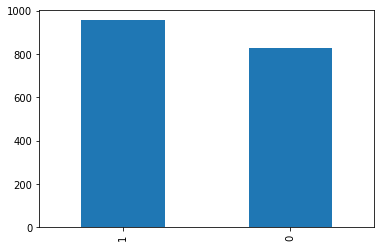

In [44]:
import matplotlib
train['status_code'].value_counts().plot(kind = 'bar')

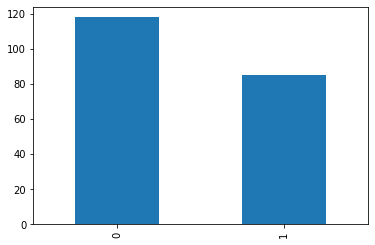

In [45]:
val['status_code'].value_counts().plot(kind = 'bar')

In [46]:
DATA_COLUMN = 'status_txt'
LABEL_COLUMN = 'status_code'
# label_list is the list of labels, i.e. True, False or 0, 1 or 'dog', 'cat'
label_list = [0,1]

preprocess the data

In [47]:
# Use the InputExample class from BERT's run_classifier code to create examples from the data
train_InputExamples = train.apply(lambda x: bert.run_classifier.InputExample(guid=None,
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

dev_InputExamples = val.apply(lambda x: bert.run_classifier.InputExample(guid=None, 
                                                                   text_a = x[DATA_COLUMN], 
                                                                   text_b = None, 
                                                                   label = x[LABEL_COLUMN]), axis = 1)

Tokenization

In [48]:
# This is a path to an uncased (all lowercase) version of BERT
BERT_MODEL_HUB = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"

def create_tokenizer_from_hub_module():
  """Get the vocab file and casing info from the Hub module."""
  with tf.Graph().as_default():
    bert_module = hub.Module(BERT_MODEL_HUB)
    tokenization_info = bert_module(signature="tokenization_info", as_dict=True)
    with tf.Session() as sess:
      vocab_file, do_lower_case = sess.run([tokenization_info["vocab_file"],
                                            tokenization_info["do_lower_case"]])
      
  return bert.tokenization.FullTokenizer(
      vocab_file=vocab_file, do_lower_case=do_lower_case)

tokenizer = create_tokenizer_from_hub_module()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [49]:
tokenizer.tokenize("This here's an example of using the BERT tokenizer")

['this',
 'here',
 "'",
 's',
 'an',
 'example',
 'of',
 'using',
 'the',
 'bert',
 'token',
 '##izer']

In [50]:
print(tokenizer.tokenize(train_InputExamples.iloc[0].text_a))

['monitor', 'in', '2019', '.']


In [51]:
#We'll set sequences to be at most 128 tokens long.
MAX_SEQ_LENGTH = 128
# Convert our train and test features to InputFeatures that BERT understands.
train_features = bert.run_classifier.convert_examples_to_features(train_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)
test_features = bert.run_classifier.convert_examples_to_features(dev_InputExamples, label_list, MAX_SEQ_LENGTH, tokenizer)

INFO:tensorflow:Writing example 0 of 1783
INFO:tensorflow:Writing example 0 of 1783
INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: None
INFO:tensorflow:guid: None
INFO:tensorflow:tokens: [CLS] monitor in 2019 . [SEP]
INFO:tensorflow:tokens: [CLS] monitor in 2019 . [SEP]
INFO:tensorflow:input_ids: 101 8080 1999 10476 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_ids: 101 8080 1999 10476 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_mask: 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [52]:
#Example on first observation in the training set
print("Sentence : ", train_InputExamples.iloc[0].text_a)
print("-"*30)
print("Tokens : ", tokenizer.tokenize(train_InputExamples.iloc[0].text_a))
print("-"*30)
print("Input IDs : ", train_features[0].input_ids)
print("-"*30)
print("Input Masks : ", train_features[0].input_mask)
print("-"*30)
print("Segment IDs : ", train_features[0].segment_ids)

Sentence :  Monitor in 2019.
------------------------------
Tokens :  ['monitor', 'in', '2019', '.']
------------------------------
Input IDs :  [101, 8080, 1999, 10476, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
------------------------------
Input Masks :  [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
----------------------

# Creating a model

Now that we've prepared our data, let's focus on building a model. 

First, it loads the BERT tf hub module again (this time to extract the computation graph). 
Next, it creates a single new layer that will be trained to adapt BERT to our task --> fine-tuning 

In [53]:
def create_model(is_predicting, input_ids, input_mask, segment_ids, labels,
                 num_labels):
  """Creates a classification model."""

  bert_module = hub.Module(
      BERT_MODEL_HUB,
      trainable=True)
  bert_inputs = dict(
      input_ids=input_ids,
      input_mask=input_mask,
      segment_ids=segment_ids)
  bert_outputs = bert_module(
      inputs=bert_inputs,
      signature="tokens",
      as_dict=True)

  # Use "pooled_output" for classification tasks on an entire sentence.
  # Use "sequence_outputs" for token-level output.
  output_layer = bert_outputs["pooled_output"]

  hidden_size = output_layer.shape[-1].value

  # Create our own layer to tune for politeness data.
  output_weights = tf.get_variable(
      "output_weights", [num_labels, hidden_size],
      initializer=tf.truncated_normal_initializer(stddev=0.02))

  output_bias = tf.get_variable(
      "output_bias", [num_labels], initializer=tf.zeros_initializer())

  with tf.variable_scope("loss"):

    # Dropout helps prevent overfitting
    output_layer = tf.nn.dropout(output_layer, keep_prob=0.9)

    logits = tf.matmul(output_layer, output_weights, transpose_b=True)
    logits = tf.nn.bias_add(logits, output_bias)
    log_probs = tf.nn.log_softmax(logits, axis=-1)

    # Convert labels into one-hot encoding
    one_hot_labels = tf.one_hot(labels, depth=num_labels, dtype=tf.float32)

    predicted_labels = tf.squeeze(tf.argmax(log_probs, axis=-1, output_type=tf.int32))
    # If we're predicting, we want predicted labels and the probabiltiies.
    if is_predicting:
      return (predicted_labels, log_probs)

    # If we're train/eval, compute loss between predicted and actual label
    per_example_loss = -tf.reduce_sum(one_hot_labels * log_probs, axis=-1)
    loss = tf.reduce_mean(per_example_loss)
    return (loss, predicted_labels, log_probs)



In [54]:
# model_fn_builder actually creates our model function
# using the passed parameters for num_labels, learning_rate, etc.
def model_fn_builder(num_labels, learning_rate, num_train_steps,
                     num_warmup_steps):
  """Returns `model_fn` closure for TPUEstimator."""
  def model_fn(features, labels, mode, params):  # pylint: disable=unused-argument
    """The `model_fn` for TPUEstimator."""

    input_ids = features["input_ids"]
    input_mask = features["input_mask"]
    segment_ids = features["segment_ids"]
    label_ids = features["label_ids"]

    is_predicting = (mode == tf.estimator.ModeKeys.PREDICT)
    
    # TRAIN and EVAL
    if not is_predicting:

      (loss, predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      train_op = bert.optimization.create_optimizer(
          loss, learning_rate, num_train_steps, num_warmup_steps, use_tpu=False)

      # Calculate evaluation metrics. 
      def metric_fn(label_ids, predicted_labels):
        accuracy = tf.metrics.accuracy(label_ids, predicted_labels)
        f1_score = tf.contrib.metrics.f1_score(
            label_ids,
            predicted_labels)
        auc = tf.metrics.auc(
            label_ids,
            predicted_labels)
        true_pos = tf.metrics.true_positives(
            label_ids,
            predicted_labels)
        true_neg = tf.metrics.true_negatives(
            label_ids,
            predicted_labels)   
        false_pos = tf.metrics.false_positives(
            label_ids,
            predicted_labels)  
        false_neg = tf.metrics.false_negatives(
            label_ids,
            predicted_labels)
    
        return {
            "eval_accuracy": accuracy, # free to change
            "f1_score": f1_score,
            "auc": auc,
            "true_positives": true_pos,
            "true_negatives": true_neg,
            "false_positives": false_pos,
            "false_negatives": false_neg 
        }

      eval_metrics = metric_fn(label_ids, predicted_labels)

      if mode == tf.estimator.ModeKeys.TRAIN:
        return tf.estimator.EstimatorSpec(mode=mode,
          loss=loss,
          train_op=train_op)
      else:
          return tf.estimator.EstimatorSpec(mode=mode,
            loss=loss,
            eval_metric_ops=eval_metrics)
    else:
      (predicted_labels, log_probs) = create_model(
        is_predicting, input_ids, input_mask, segment_ids, label_ids, num_labels)

      predictions = {
          'probabilities': log_probs,
          'labels': predicted_labels
      }
      return tf.estimator.EstimatorSpec(mode, predictions=predictions)

  # Return the actual model function in the closure
  return model_fn

In [55]:
# Compute train and warmup steps from batch size
# These hyperparameters are copied from this colab notebook (https://colab.sandbox.google.com/github/tensorflow/tpu/blob/master/tools/colab/bert_finetuning_with_cloud_tpus.ipynb)
BATCH_SIZE = 32
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3.0
# Warmup is a period of time where hte learning rate 
# is small and gradually increases--usually helps training.
WARMUP_PROPORTION = 0.1
# Model configs
SAVE_CHECKPOINTS_STEPS = 50 # original: 500
SAVE_SUMMARY_STEPS = 10 # original: 100

In [56]:
# Compute # train and warmup steps from batch size
num_train_steps = int(len(train_features) / BATCH_SIZE * NUM_TRAIN_EPOCHS)
num_warmup_steps = int(num_train_steps * WARMUP_PROPORTION)

In [57]:
# Specify outpit directory and number of checkpoint steps to save
run_config = tf.estimator.RunConfig(
    model_dir=OUTPUT_DIR,
    save_summary_steps=SAVE_SUMMARY_STEPS,
    save_checkpoints_steps=SAVE_CHECKPOINTS_STEPS)

In [58]:
model_fn = model_fn_builder(
  num_labels=len(label_list),
  learning_rate=LEARNING_RATE,
  num_train_steps=num_train_steps,
  num_warmup_steps=num_warmup_steps)

estimator = tf.estimator.Estimator(
  model_fn=model_fn,
  config=run_config,
  params={"batch_size": BATCH_SIZE})

INFO:tensorflow:Using config: {'_model_dir': './output', '_tf_random_seed': None, '_save_summary_steps': 10, '_save_checkpoints_steps': 50, '_save_checkpoints_secs': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000230756CFB08>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Using config: {'_model_dir': './output', '_tf_random_seed': None, '_save_summary_ste

# Train the model
First, we create an input builder function that takes our training feature set (train_features) and produces a generator. 

In [59]:
# Create an input function for training. drop_remainder = True for using TPUs.
train_input_fn = bert.run_classifier.input_fn_builder(
    features=train_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=True,
    drop_remainder=False)

And we begin training 

In [60]:
print(f'Beginning Training!')
current_time = datetime.now()
estimator.train(input_fn=train_input_fn, max_steps=num_train_steps)
print("Training took time ", datetime.now() - current_time)

Beginning Training!
INFO:tensorflow:Skipping training since max_steps has already saved.
INFO:tensorflow:Skipping training since max_steps has already saved.
Training took time  0:00:00.109967


In [61]:
test_input_fn = run_classifier.input_fn_builder(
    features=test_features,
    seq_length=MAX_SEQ_LENGTH,
    is_training=False,
    drop_remainder=False)

In [62]:
estimator.evaluate(input_fn=test_input_fn, steps=None) # around 2 min

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not lis

{'auc': 0.903988,
 'eval_accuracy': 0.91133004,
 'f1_score': 0.8902439,
 'false_negatives': 12.0,
 'false_positives': 6.0,
 'loss': 0.22250065,
 'true_negatives': 112.0,
 'true_positives': 73.0,
 'global_step': 167}

Here we can see the evaluation accuracy is pretty high. And the loss is small enough. 

# Prediction 

Now we can use this model to predict on our unlabelled dataset. 

In [63]:
# A method to get predictions
import numpy as np
def prediction(sent):
  #A list to map the actual labels to the predictions
  labels = ["Unresolved", "Resolved"]

  #Transforming the test data into BERT accepted form
  input_examples = [run_classifier.InputExample(guid="", text_a = x, text_b = None, label = 0) for x in sent] 
  
  #Creating input features for Test data
  input_features = run_classifier.convert_examples_to_features(input_examples, label_list, MAX_SEQ_LENGTH, tokenizer)

  #Predicting the classes 
  predict_input_fn = run_classifier.input_fn_builder(features=input_features, seq_length=MAX_SEQ_LENGTH, is_training=False, drop_remainder=False)
  predictions = estimator.predict(predict_input_fn)
  return [(sentence, np.exp(prediction['probabilities']),prediction['labels'], labels[prediction['labels']]) for sentence, prediction in zip(sent, predictions)]

In [64]:
sentences = list(test['status_txt'])

In [65]:
pred = prediction(sentences) 

INFO:tensorflow:Writing example 0 of 9724
INFO:tensorflow:Writing example 0 of 9724
INFO:tensorflow:*** Example ***
INFO:tensorflow:*** Example ***
INFO:tensorflow:guid: 
INFO:tensorflow:guid: 
INFO:tensorflow:tokens: [CLS] june 22 , 2016 – intermittent weeds observed , recommend implementation of control measures . [SEP]
INFO:tensorflow:tokens: [CLS] june 22 , 2016 – intermittent weeds observed , recommend implementation of control measures . [SEP]
INFO:tensorflow:input_ids: 101 2238 2570 1010 2355 1516 23852 20777 5159 1010 16755 7375 1997 2491 5761 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
INFO:tensorflow:input_ids: 101 2238 2570 1010 2355 1516 23852 20777 5159 1010 16755 7375 1997 2491 5761 1012 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [68]:
pred[10:20]

[('Sept 17, 2016  - Installed TC sign and marker posts at KP 0+040.',
  array([0.9244605 , 0.07553951], dtype=float32),
  0,
  'Unresolved'),
 ('Sept 17, 2016  - Re-installed marker posts at KP 0+300, issue resolved.',
  array([0.974542  , 0.02545802], dtype=float32),
  0,
  'Unresolved'),
 ('Sept 17, 2016  - Intermittent herbicide application conducted to control perennial sow thistle.',
  array([0.9166226 , 0.08337741], dtype=float32),
  0,
  'Unresolved'),
 ('June 22, 2016 – Intermittent weeds observed, recommend implementation of control measures.',
  array([0.9778006 , 0.02219943], dtype=float32),
  0,
  'Unresolved'),
 ('July 13, 2016 - Vegetation continues to establish with desirable species throughout ROW. Diverse mix of vegetation observed.',
  array([0.1345844, 0.8654156], dtype=float32),
  1,
  'Resolved'),
 ('July 13, 2016  - Cross drains are vegetated and functioning.',
  array([0.65626764, 0.34373248], dtype=float32),
  0,
  'Unresolved'),
 ('July 13, 2016   - Wetlands st

In [69]:
pred_test_df = pd.DataFrame(pred, columns = ['sentence', 'pred_prob', 'pred_status_code', 'pred_status_label'])
pred_test_df

,sentence,pred_prob,pred_status_code,pred_status_label
0,"June 22, 2016 – Intermittent weeds observed, r...","[0.9811199, 0.018880144]",0,Unresolved
1,"July 13, 2016 - Vegetation continues to establ...","[0.12334013, 0.8766598]",1,Resolved
2,"July 13, 2016 - Cross drains are vegetated an...","[0.67395425, 0.32604575]",0,Unresolved
3,"July 13, 2016 - Wetlands stable and consiste...","[0.7411269, 0.25887313]",0,Unresolved
4,"July 13, 2016 - No erosion or subsidence issues.","[0.22900935, 0.7709906]",1,Resolved
...,...,...,...,...
9719,"Aug 18, 2017 - Vegetation established at 65-80...","[0.10008355, 0.8999164]",1,Resolved
9720,"Aug 18, 2017 – Intermittent perennial sow thi...","[0.205278, 0.794722]",1,Resolved
9721,"Aug 23, 2017 – Intermittent herbicide applicat...","[0.40741158, 0.5925885]",1,Resolved
9722,.,"[0.027569667, 0.97243035]",1,Resolved


In [70]:
pred_test_df['unresolved_prob'], pred_test_df['resolved_prob'] = zip(*pred_test_df['pred_prob'])
pred_test_df

,sentence,pred_prob,pred_status_code,pred_status_label,unresolved_prob,resolved_prob
0,"June 22, 2016 – Intermittent weeds observed, r...","[0.9811199, 0.018880144]",0,Unresolved,0.981120,0.018880
1,"July 13, 2016 - Vegetation continues to establ...","[0.12334013, 0.8766598]",1,Resolved,0.123340,0.876660
2,"July 13, 2016 - Cross drains are vegetated an...","[0.67395425, 0.32604575]",0,Unresolved,0.673954,0.326046
3,"July 13, 2016 - Wetlands stable and consiste...","[0.7411269, 0.25887313]",0,Unresolved,0.741127,0.258873
4,"July 13, 2016 - No erosion or subsidence issues.","[0.22900935, 0.7709906]",1,Resolved,0.229009,0.770991
...,...,...,...,...,...,...
9719,"Aug 18, 2017 - Vegetation established at 65-80...","[0.10008355, 0.8999164]",1,Resolved,0.100084,0.899916
9720,"Aug 18, 2017 – Intermittent perennial sow thi...","[0.205278, 0.794722]",1,Resolved,0.205278,0.794722
9721,"Aug 23, 2017 – Intermittent herbicide applicat...","[0.40741158, 0.5925885]",1,Resolved,0.407412,0.592588
9722,.,"[0.027569667, 0.97243035]",1,Resolved,0.027570,0.972430


In [71]:
test['predicted_prob'] = pred_test_df['pred_prob']
test['predicted_status_code'] = pred_test_df['pred_status_code']
test['predicted_status_label'] = pred_test_df['pred_status_label']
test['unresolved_probability'] = pred_test_df['unresolved_prob']
test['resolved_probability'] = pred_test_df['resolved_prob']

In [73]:
test.to_csv(r'C:\Users\t1nipun\Desktop\PCMR\human-robot\Data_Analysis\issues_parsed_status.csv', encoding = 'utf-8-sig', index = False)

In [ ]:
val['predicted_prob'] = pred_test_df['pred_prob']
val['predicted_status_code'] = pred_val_df['pred_status_code']
val['predicted_status_label'] = pred_val_df['pred_status_label']
val['unresolved_probability'] = pred_val_df['unresolved_prob']
val['resolved_probability'] = pred_val_df['resolved_prob']

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import numpy as np
plt.hist(val.unresolved_probability)
plt.show()

In [ ]:
fig, axs = plt.subplots(ncols=2)
#axs = plt.subplots(ncols = 2)
val.groupby("status").unresolved_probability.plot(kind='kde', ax=axs[1], legend = True)
val.groupby("status").unresolved_probability.hist(alpha=0.4, ax=axs[0])

In [ ]:
fig, axs = plt.subplots(ncols=2)
#axs = plt.subplots(ncols = 2)
val.groupby("status").resolved_probability.plot(kind='kde', ax=axs[1], legend = True)
val.groupby("status").resolved_probability.hist(alpha=0.4, ax=axs[0])

In [ ]:
val.to_csv('predicted_valSet.csv', encoding = 'utf-8-sig', index = False)

In [ ]:
test.to_csv('predicted_testSet.csv', encoding = 'utf-8-sig', index = False)